In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 16, 16)
latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
kappa = 0.125
# dtype = torch.complex128
dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = clover.add_I(clover=clover_term)  # needed!
# clover_term = clover.add_I(clover=torch.zeros_like(clover_term))  # test

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
U_eo = xxxtzyx2pxxxtzyx(input_array=U)
clover_eo = xxxtzyx2pxxxtzyx(input_array=clover_term)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support (when '#define _B

In [2]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U_eo=U_eo,
                clover=clover, clover_eo=clover_eo, verbose=verbose, max_iter=50, max_restarts=2)

self.dof_list:[12, 12, 12, 12, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 8x8x8x8
  Level 1: 4x4x4x4
self.grid_list:[[8, 8, 8, 8], [4, 4, 4, 4]]

Performance Statistics:
Total iterations: 47
Total time: 0.813056 seconds
Average time per iteration: 0.017297 s
Final residual: 8.92e-04

Performance Statistics:
Total iterations: 43
Total time: 0.720351 seconds
Average time per iteration: 0.016750 s
Final residual: 9.14e-04

Performance Statistics:
Total iterations: 46
Total time: 0.628838 seconds
Average time per iteration: 0.013668 s
Final residual: 9.39e-04

Performance Statistics:
Total iterations: 50
Total time: 0.659798 seconds
Average time per iteration: 0.013194 s
Final residual: 9.02e-04

Performance Statistics:
Total iterations: 46
Total time: 0.612492 seconds
Average time per iteration: 0.013313 s
Final residual: 9.23e-04

Performance Statistics:
Total iterations: 46
Total time: 0.599794 seconds
Average time per iteration: 0.

In [3]:
# b0 = mg.b_list[0]
# b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
# _b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
# _b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
# print(_b1.flatten()[:100]/b1.flatten()[:100])

In [4]:
_x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

BICGSTAB:Iteration 0: Residual = 7.054442e+01, Time = 0.025480 s
BICGSTAB:Iteration 1: Residual = 2.913203e+01, Time = 0.012011 s
BICGSTAB:Iteration 2: Residual = 2.911068e+01, Time = 0.012241 s
BICGSTAB:Iteration 3: Residual = 1.808037e+01, Time = 0.013582 s
BICGSTAB:Iteration 4: Residual = 1.149226e+01, Time = 0.024622 s
BICGSTAB:Iteration 5: Residual = 8.366127e+00, Time = 0.017234 s
BICGSTAB:Iteration 6: Residual = 5.924591e+00, Time = 0.012888 s
BICGSTAB:Iteration 7: Residual = 1.543550e+01, Time = 0.014524 s
BICGSTAB:Iteration 8: Residual = 1.304910e+01, Time = 0.012545 s
BICGSTAB:Iteration 9: Residual = 4.028563e+01, Time = 0.012790 s
BICGSTAB:Iteration 10: Residual = 4.488453e+00, Time = 0.013371 s
BICGSTAB:Iteration 11: Residual = 4.188344e+00, Time = 0.013158 s
BICGSTAB:Iteration 12: Residual = 4.413499e+00, Time = 0.014496 s
BICGSTAB:Iteration 13: Residual = 5.222202e+00, Time = 0.014744 s
BICGSTAB:Iteration 14: Residual = 3.441170e+00, Time = 0.013535 s
BICGSTAB:Iteration 1


MG:Iteration 1:
V-cycle level 0, mg_size: [8, 8, 8, 8]
    Pre pre-smooth residual norm: 3.3299e+02
    Pre-smoothing...



Performance Statistics:
Total iterations: 2
Total time: 0.029631 seconds
Average time per iteration: 0.014766 s
Final residual: 2.91e+01
    Post pre-smooth residual norm: 2.9090e+01
restrict:shape,coarse_dof:(torch.Size([12, 12, 4, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
V-cycle level 1, mg_size: [4, 4, 4, 4]
    Pre-solve residual norm: 4.2639e+01
    Solving coarsest grid directly...

Performance Statistics:
Total iterations: 50
Total time: 0.147689 seconds
Average time per iteration: 0.002950 s
Final residual: 8.99e+00
    Post-solve residual norm: 8.9937e+00
prolong:shape,fine_dof:(torch.Size([12, 12, 4, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
    Post post-smooth residual norm: 9.7443e+02
MG:Iteration 1 completed, residual norm: 9.7443e+02

MG:Iteration 2:
V-cycle level 0, mg_size: [8, 8, 8, 8]
    Pre pre-smooth residual norm: 9.7443e+02
    Pre-smoothing...

Performance Statistics:
Total iterations: 2
Total time: 0.024709 seconds
Average time per 

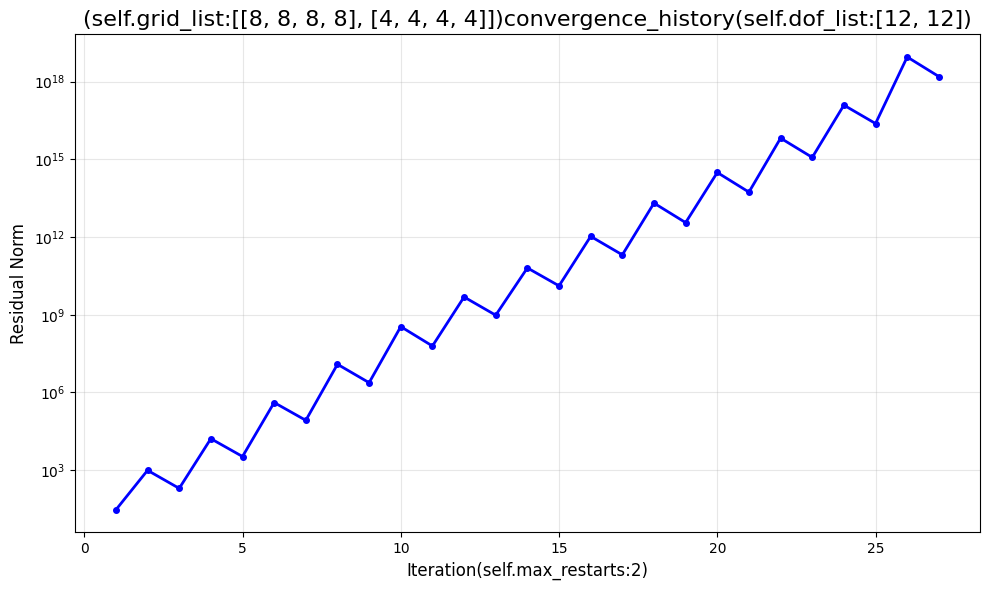

In [5]:
x = mg.solve()
mg.plot()

In [6]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

nan


In [7]:
mg.b_list[-1].flatten()[:100]

tensor([nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+